In [ ]:
import sys
sys.path.append("../")

In [ ]:
from utils.draw_candle_image import *
from functools import partial
from keras import layers, Model
from keras.models import load_model
from ta import add_all_ta_features
from ta.utils import dropna
from utils.common_train_utils import *
import json
import keras
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import ta
import ta.momentum
import ta.trend
import tensorflow as tf

In [3]:
dataset_folder = "./dataset_3_2_3_2023"

In [4]:
config = read_config(dataset_folder)
candle_type_and_directory_save: dict = config["candle_type_and_directory_save"]
previous_days = config["previous_days"]
next_days = config["next_days"]
days_result = config["days_result"]

In [5]:
dataset_test = load_dataset_test(dataset_folder)

In [6]:
for images, labels in dataset_test.take(1):
    print(images.shape)
    print(labels.shape)
    

(287, 287, 3)
(9, 4)


In [7]:
image_shape = tuple(images.shape)

In [8]:
image_shape

(287, 287, 3)

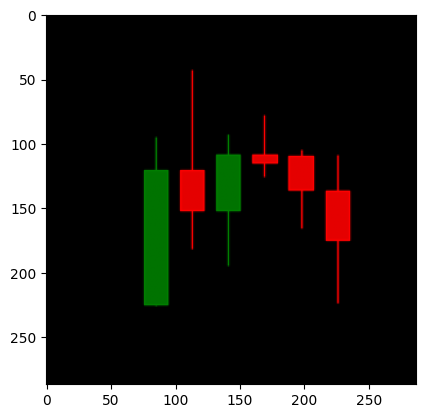

In [9]:
plt.imshow(images)

In [10]:
dataset_test

<_LoadDataset element_spec=(TensorSpec(shape=(287, 287, 3), dtype=tf.float64, name=None), TensorSpec(shape=(9, 4), dtype=tf.float64, name=None))>

In [11]:
len(dataset_test)

30

In [12]:
dataset_train = load_dataset_train(dataset_folder, candle_type_and_directory_save)

folder: bearish_engulfing, 		 total: 35 images
folder: harami_down, 		 total: 56 images
folder: harami_up, 		 total: 37 images
folder: spin, 		 total: 19 images
folder: next_3_day_up, 		 total: 35 images
folder: next_3_day_down, 		 total: 38 images


In [13]:
len(dataset_train)

273

In [14]:
dataset_train_1 = dataset_train.batch(32)
dataset_test_1 = dataset_test.batch(32)

In [15]:
get_close_feature_1 = partial(get_close_feature, days_result)

In [16]:
dataset_train_2 = dataset_train_1.map(get_close_feature_1)
dataset_test_2 = dataset_test_1.map(get_close_feature_1)

In [17]:
dataset_train_2

<_MapDataset element_spec=(TensorSpec(shape=(None, 287, 287, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>

In [18]:
dataset_test_2

<_MapDataset element_spec=(TensorSpec(shape=(None, 287, 287, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>

In [19]:
image_shape

(287, 287, 3)

In [20]:
def expand_to_one_time(features, labels):
    features = tf.expand_dims(features, axis=1)
    return features, labels

dataset_train_3 = dataset_train_2.map(expand_to_one_time)
dataset_test_3 = dataset_test_2.map(expand_to_one_time)

In [21]:
dataset_train_3

<_MapDataset element_spec=(TensorSpec(shape=(None, 1, 287, 287, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>

In [22]:
# model.save(f"{dataset_folder}/model_2.keras")

In [23]:
model = load_model(f"{dataset_folder}/model_2.keras")

In [24]:
prediction_for_test = model.predict(dataset_test_3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


In [31]:
loss, accuracy = model.evaluate(dataset_test_3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - loss: 9.5538 - mae: 2.2679


In [32]:
loss

9.55384635925293

In [33]:
accuracy

2.2679197788238525

In [25]:
def compare_two_close():
    prediction_for_test_1 = prediction_for_test[:, 0, 0]
    
    all_y = [y.numpy() for _, y in dataset_test_1]
    y_0 = all_y[0]
    for y in all_y[1:]:
        y_0 = np.concatenate([y_0, y], axis=0)
    y_0_close = y_0[:,:,2]
    y_close_real = y_0_close[:, -days_result]
    y_last_in_candle = y_0_close[:, -days_result - 1]
    y_prediction = y_last_in_candle * prediction_for_test_1
    
    fig = plt.figure(figsize=(10, 6))
    x_range = list(range(0, len(y_prediction)))
    plt.plot(x_range, y_close_real, color='blue', linestyle='-', label='Giá Đóng cửa thật')
    plt.plot(x_range, y_prediction, color='orange', linestyle='--', label='Giá Đóng cửa dự đoán')
    plt.title('Biểu đồ Giá Đóng cửa')
    plt.xlabel('Ngày')
    plt.ylabel('Giá Đóng cửa')
    plt.legend()
    plt.grid(True)
    plt.show()

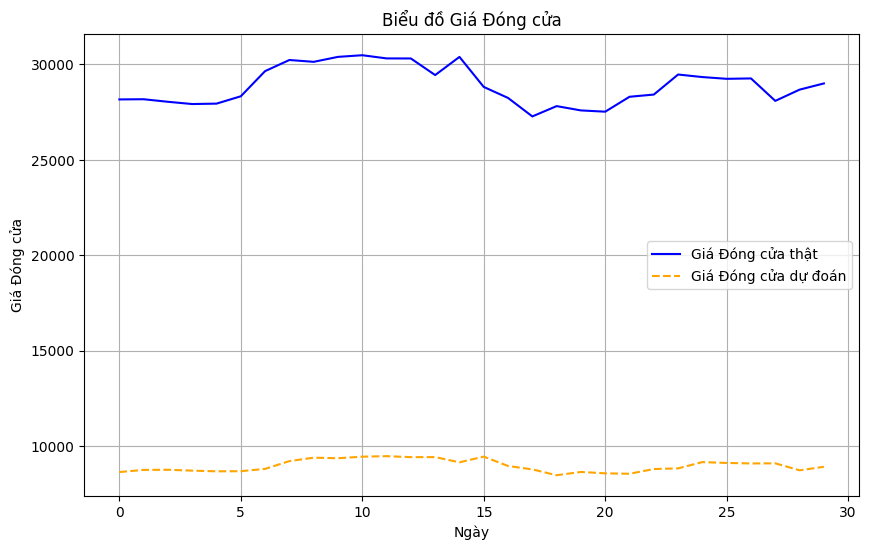

In [26]:
compare_two_close()

In [43]:
def draw_prediction(
    x_image, 
    y, 
    predictions, 
    show_x_orginal_candle=False, 
    show_original_candle=False,
    show_prediction_candle=False
    ):
    
    if show_x_orginal_candle:
        plt.imshow(x_image)
    
    df = pd.DataFrame(y.numpy(), columns=["High", "Open", "Close", "Low"])
    
    mc = mpf.make_marketcolors(
    up='green', down='red', wick='inherit', edge='inherit', volume='inherit', )
    style = mpf.make_mpf_style(marketcolors=mc, figcolor="white")
    
    df['Date'] = pd.date_range(start='2023-01-01', periods=len(df), freq='D')
    df.set_index('Date', inplace=True)
    
    if show_original_candle:
        fig, axlist = mpf.plot(
            df,
            type='candle',
            style=style,
            volume=False,  # Hiển thị khối lượng
            axisoff=not False,  # Bỏ trục x và y
            returnfig=True,  # Trả về đối tượng Figure để tùy chỉnh
            figratio=(5, 5),  # Điều chỉnh tỷ lệ khung hình để thu hẹp khoảng cách
            figscale=1,  # Tăng kích thước biểu đồ để làm các nến gần nhau hơn
            panel_ratios=[6]
        )
    
    df_predictions = df.copy()
    last_close_in_x_original_candle = df_predictions.iloc[-days_result-1, 2]
    df_predictions.iloc[-days_result:, 2] = (predictions.reshape(1,-1)[0]) * last_close_in_x_original_candle
    
    if show_prediction_candle:
        fig, axlist = mpf.plot(
            df_predictions,
            type='candle',
            style=style,
            volume=False,  # Hiển thị khối lượng
            axisoff=not False,  # Bỏ trục x và y
            returnfig=True,  # Trả về đối tượng Figure để tùy chỉnh
            figratio=(5, 5),  # Điều chỉnh tỷ lệ khung hình để thu hẹp khoảng cách
            figscale=1,  # Tăng kích thước biểu đồ để làm các nến gần nhau hơn
            panel_ratios=[6]
        )
    
    
    fig = plt.figure(figsize=(10, 6))
    plt.plot(df.index, df["Close"], color='blue', marker='o', linestyle='-', label='Giá Đóng cửa thật')
    plt.plot(df.index, df_predictions["Close"], color='orange', marker='x', linestyle='--', label='Giá Đóng cửa dự đoán')
    plt.title('Biểu đồ Giá Đóng cửa')
    plt.xlabel('Ngày')
    plt.ylabel('Giá Đóng cửa')
    plt.legend()
    plt.grid(True)
    plt.show()

In [44]:
for x, y in dataset_test_1.take(1):
    break

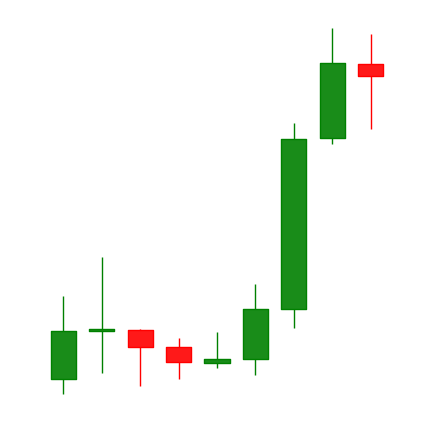

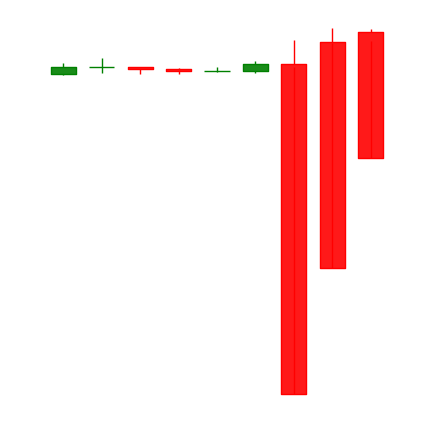

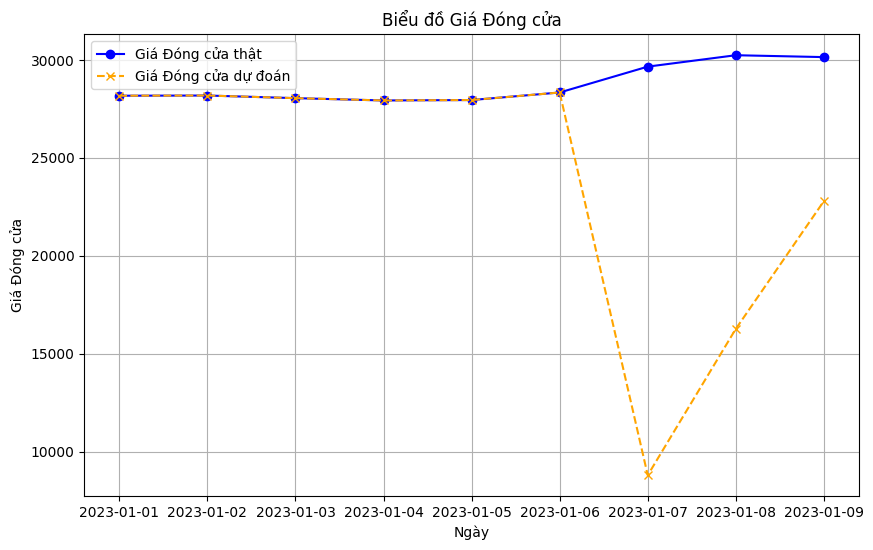

In [45]:
index = 6
draw_prediction(x[index], y[index], prediction_for_test[index], show_prediction_candle=True, show_original_candle=True)